I. Preparing and split dataset
I.1 Read and encoded data

Attributes:
Sex:
- Female: encoded as 0 using LabelEncoder.
- Male: encoded as 1 using LabelEncoder.
Island:
- The values such as Biscoe, Dream, and Torgersen are encoded as different integers (e.g., 0, 1, 2) based on the alphabetical order in the original data.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns


data = pd.read_csv('penguins.csv')
data = data.dropna()

feature = data[['island', 'bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g', 'sex']]
label = data['species']

feature_encoded = feature.copy()

feature_encoded['island'] = feature_encoded['island'].map({'Biscoe': 0, 'Dream': 1, 'Torgersen': 2})
feature_encoded['sex'] = feature_encoded['sex'].map({'Male': 0, 'Female': 1})




I.2 Visualizing the Original Dataset
The Palmer Penguins dataset is used for classifying penguin species based on physical characteristics. The dataset includes 344 samples of three penguin species: Adelie, Chinstrap, and Gentoo, with features such as bill length, flipper length, body mass, and sex

Since the original penguins.csv dataset contains some rows with missing values (NaN) in columns such as "sex", "flipper_length_mm", "bill_length_mm", etc., using dropna() results in a reduction in the dataset size. (333 samples)

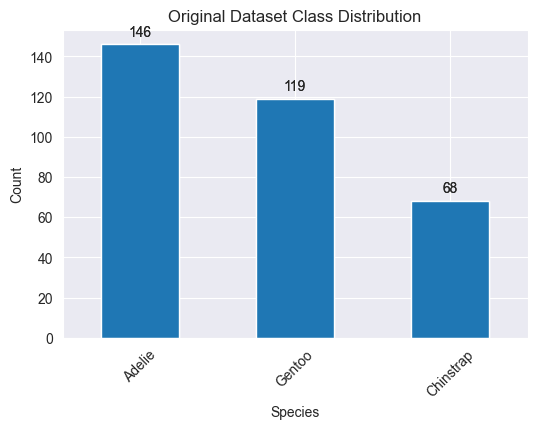

In [3]:

plt.figure(figsize=(6,4))
ax = label.value_counts().plot(kind='bar')

label.value_counts().plot(kind='bar')
plt.title("Original Dataset Class Distribution")
plt.xlabel("Species")
plt.ylabel("Count")
plt.tick_params(axis = 'x', rotation = 45)

for p in ax.patches:  
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),  
                ha='center', va='center',  
                xytext=(0, 9),  
                textcoords='offset points')
plt.show()


I.3 Split dataset
We will split the data according to the ratios 60/40, 40/60, 20/80, 10/90, with a fixed random_state of 0.

In [4]:
split_ratios = [0.4, 0.6, 0.8, 0.9]
random_state = [0]

datasets = []


for ratio in split_ratios:
    for seed in random_state:
        feature_train, feature_test, label_train, label_test = train_test_split(
            feature_encoded, label,
            train_size = ratio,
            random_state = seed,
            shuffle = True,
            stratify = label,
        )
        
        datasets.append({
            'ratio': ratio,
            'seed': seed,
            'feature_train': feature_train,
            'feature_test': feature_test,
            'label_train': label_train,
            'label_test': label_test,
        })


I.4 Visualizing the Train Dataset and Test Dataset

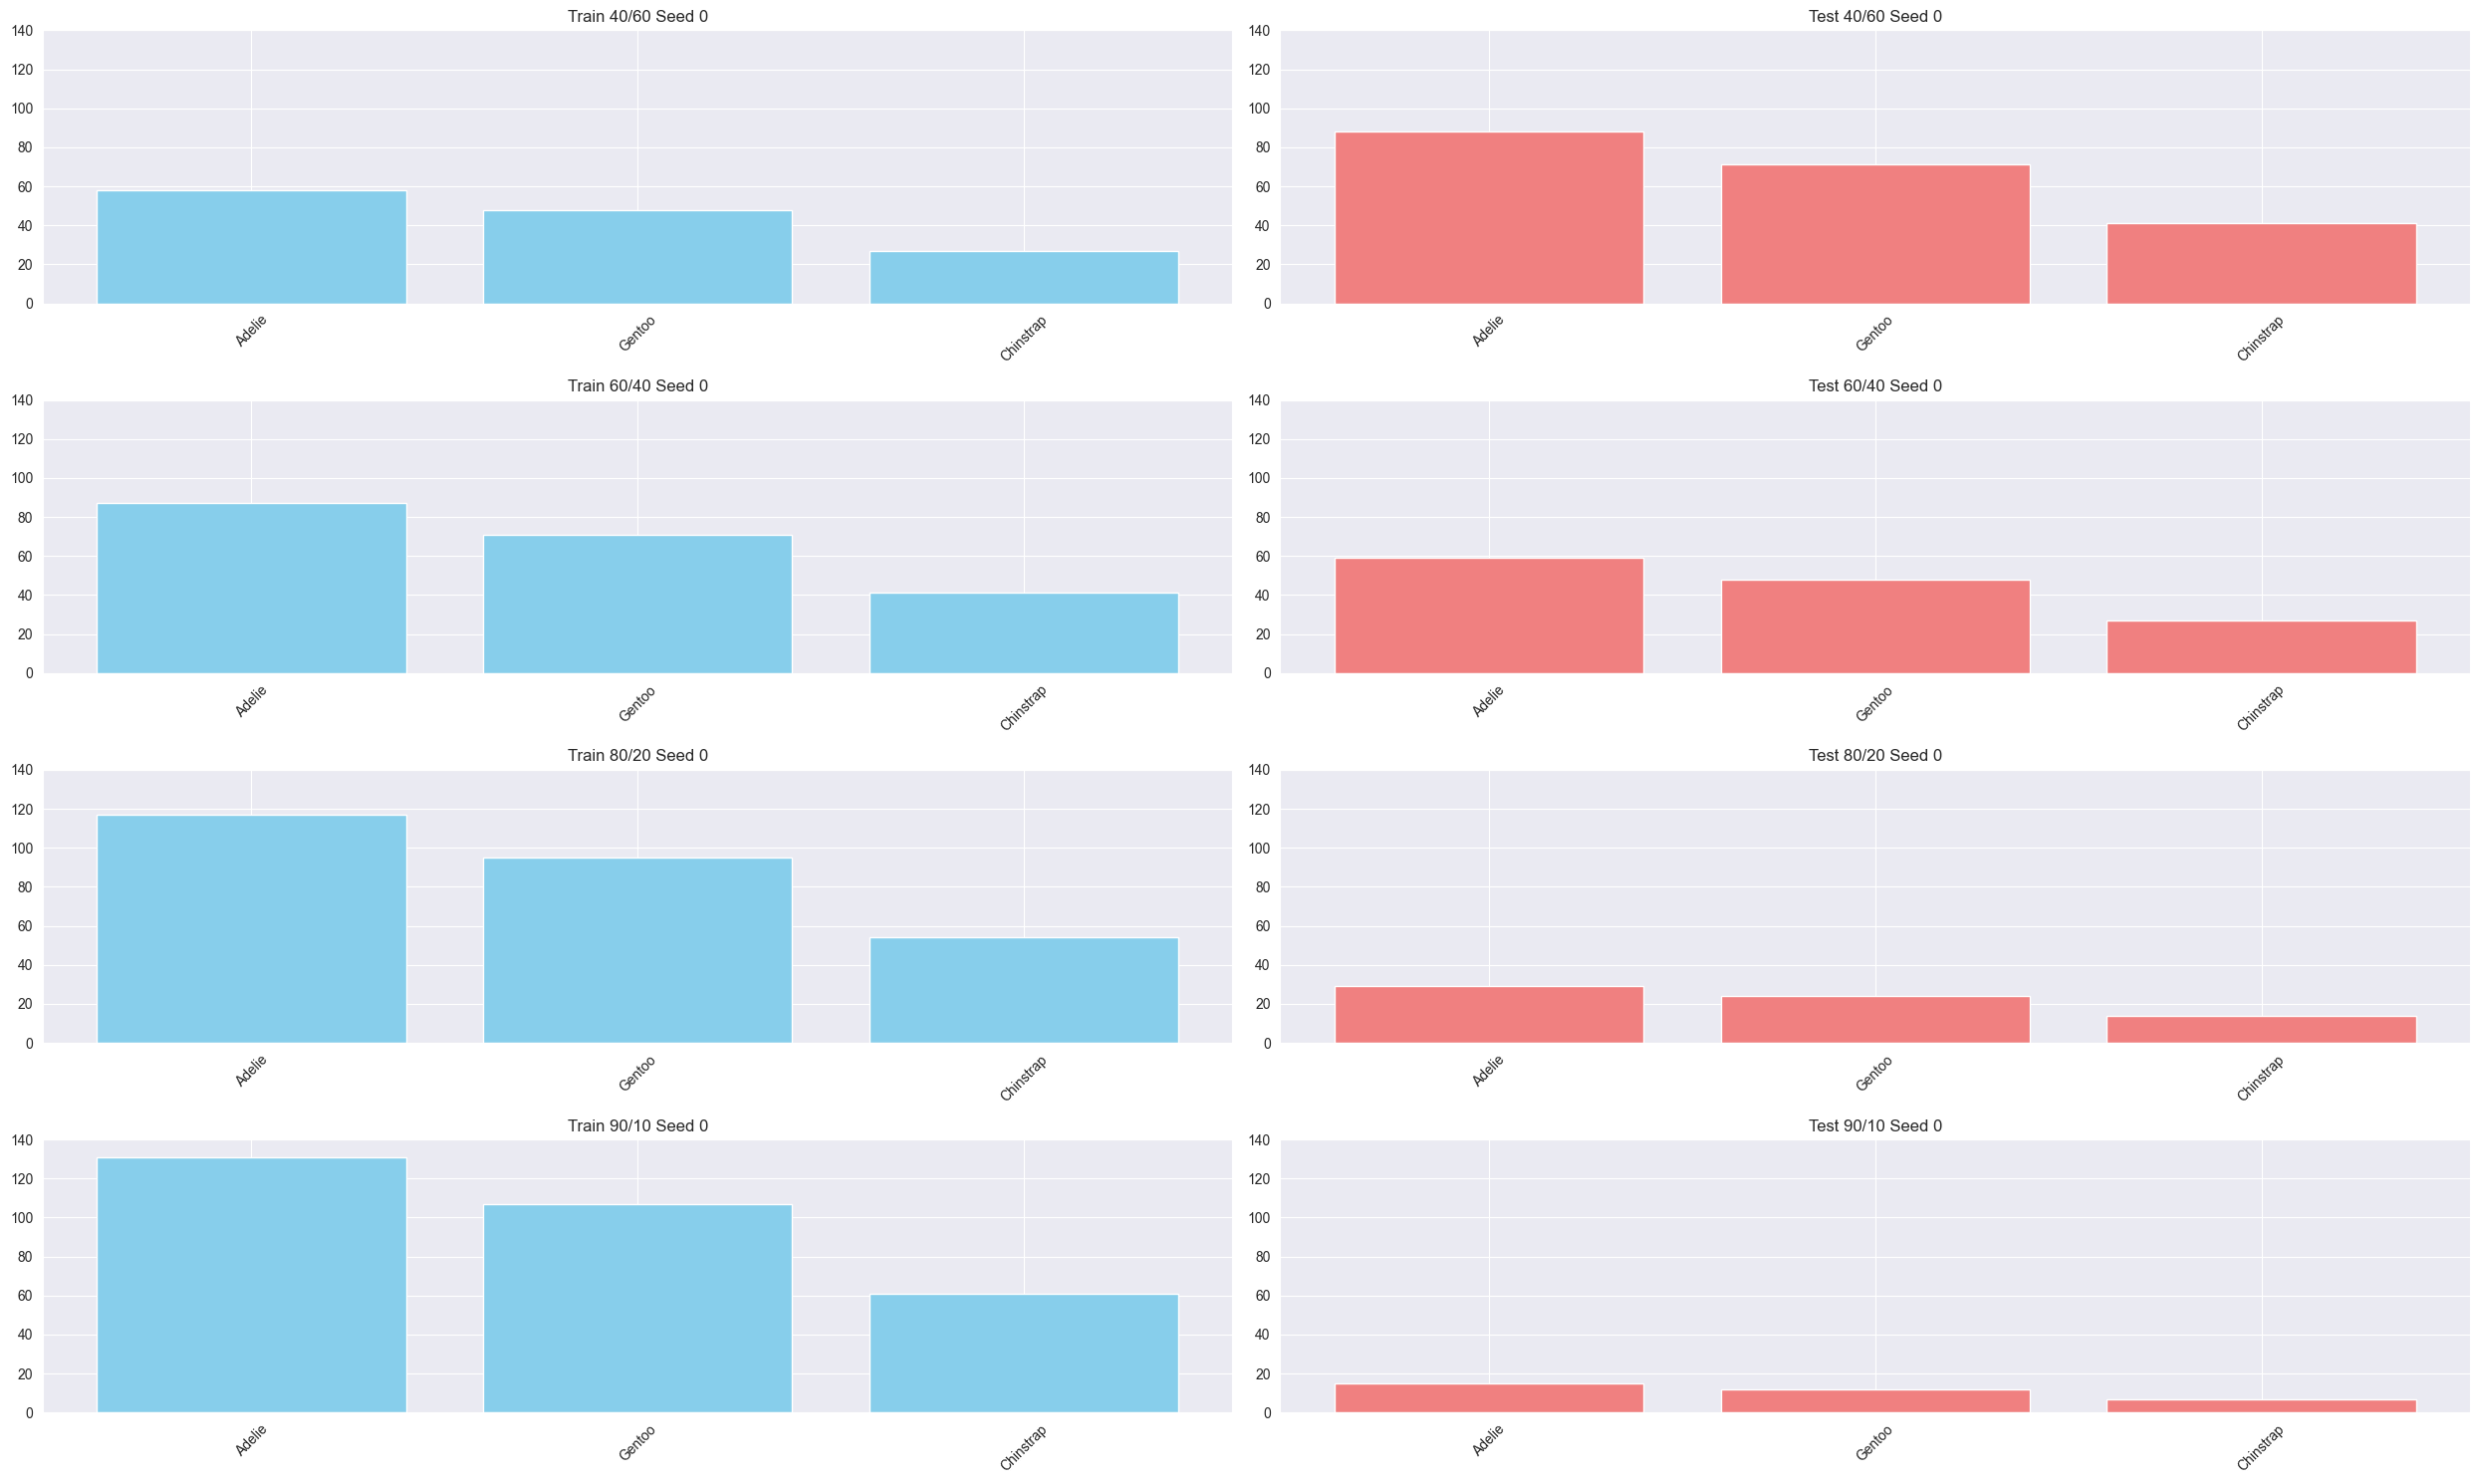

In [5]:
fig, axes = plt.subplots(len(split_ratios), len(random_state)*2, figsize=(25, 15))

for idx, dataset in enumerate(datasets):
    row = idx // len(random_state)
    col = (idx % len(random_state)) * 2

    # Training set plot
    axes[row, col].bar(dataset['label_train'].value_counts().index, dataset['label_train'].value_counts().values, color='skyblue')
    axes[row, col].set_title(f"Train {int(dataset['ratio']*100)}/{100-int(dataset['ratio']*100)} Seed {dataset['seed']}")
    axes[row, col].tick_params(axis='x', rotation=45)
    axes[row, col].set_ylim(0, 140)

    # Testing set plot
    axes[row, col + 1].bar(dataset['label_test'].value_counts().index, dataset['label_test'].value_counts().values, color='lightcoral')
    axes[row, col + 1].set_title(f"Test {int(dataset['ratio']*100)}/{100-int(dataset['ratio']*100)} Seed {dataset['seed']}")
    axes[row, col + 1].tick_params(axis='x', rotation=45)
    axes[row, col + 1].set_ylim(0, 140)

plt.tight_layout()
plt.show()


II. Building the decision tree classifiers
II.1 Building the decision tree.

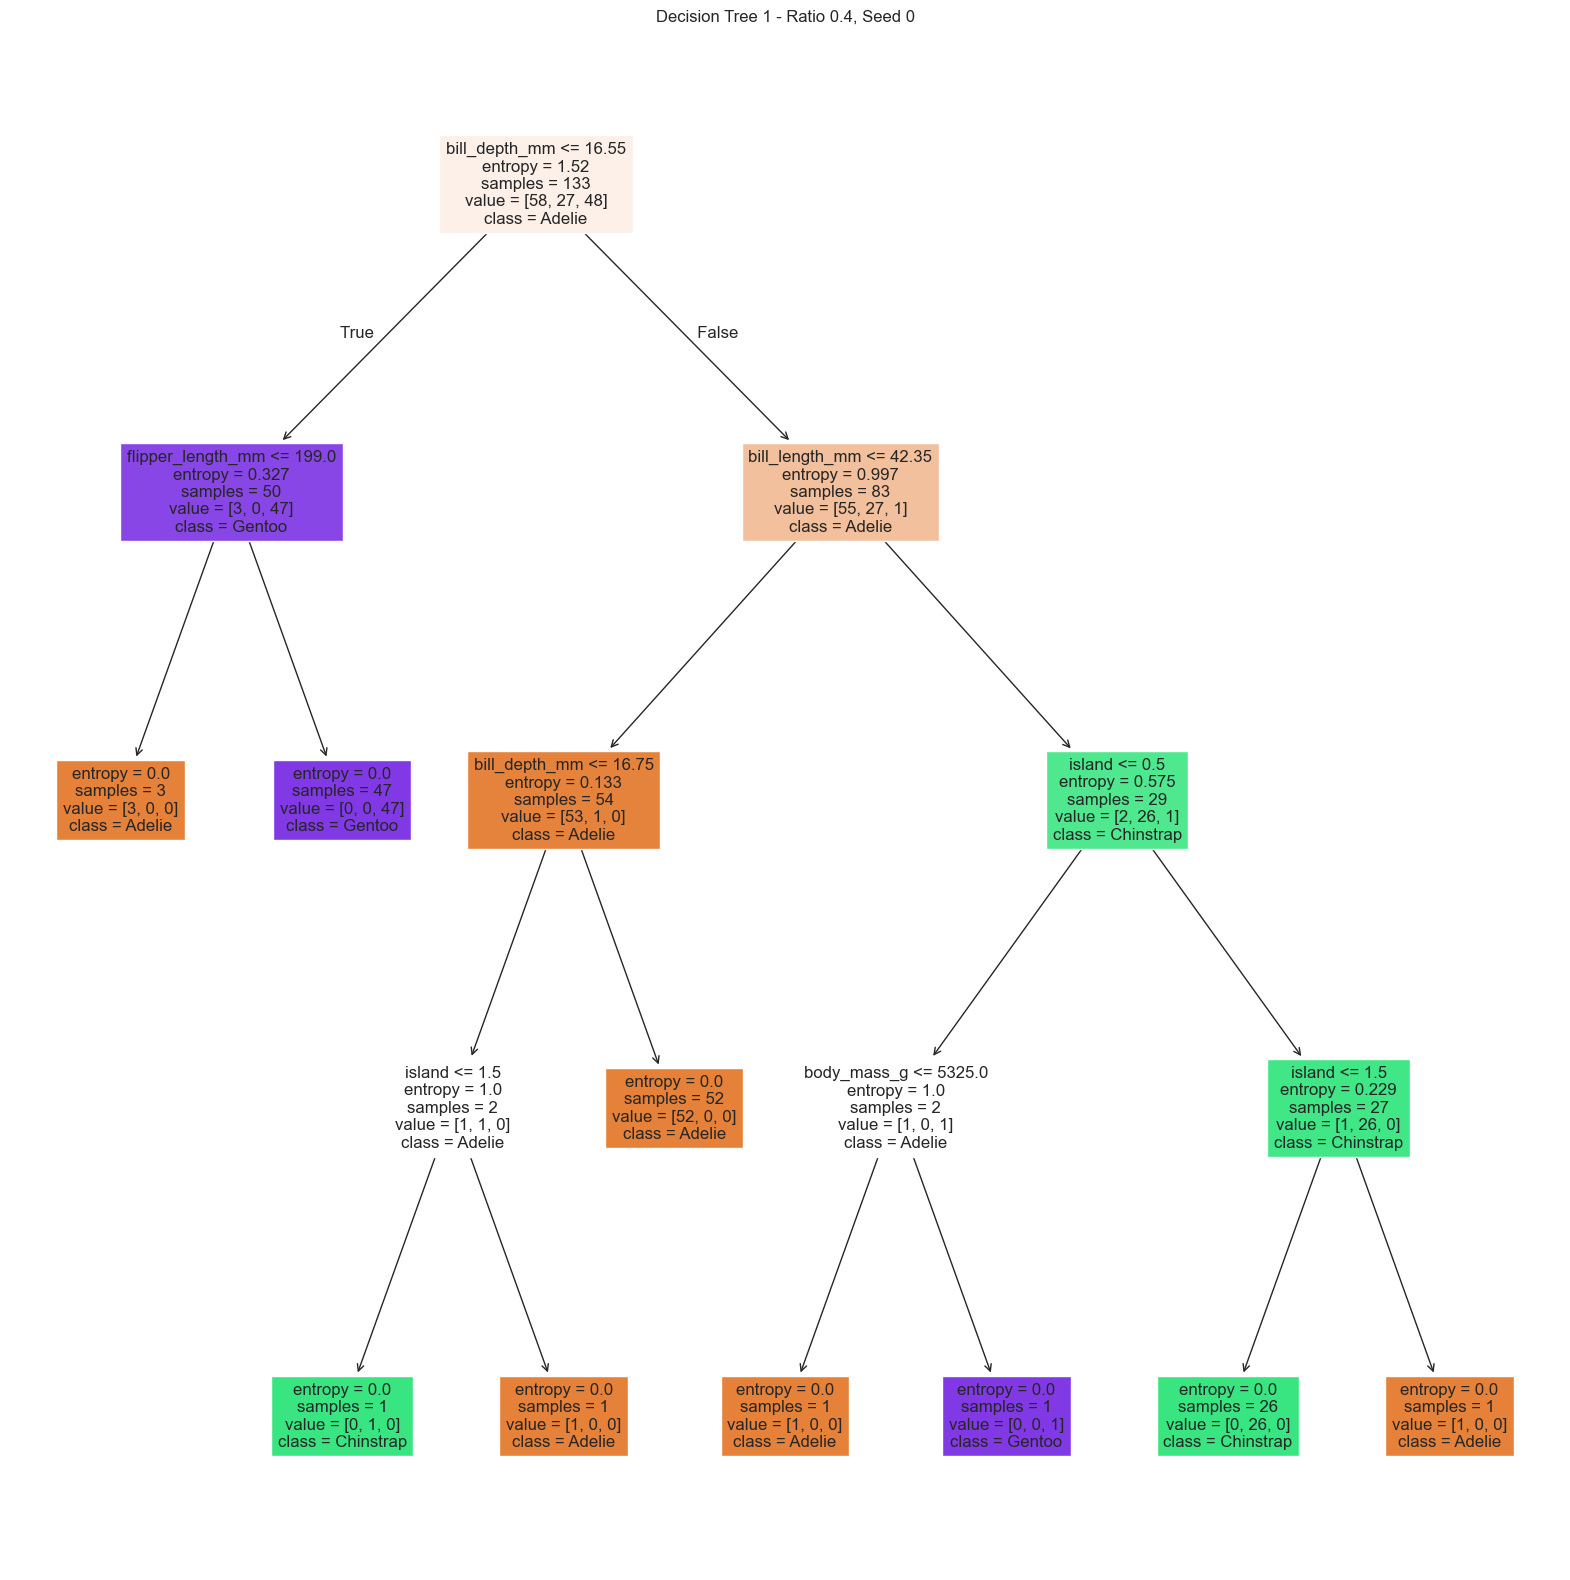

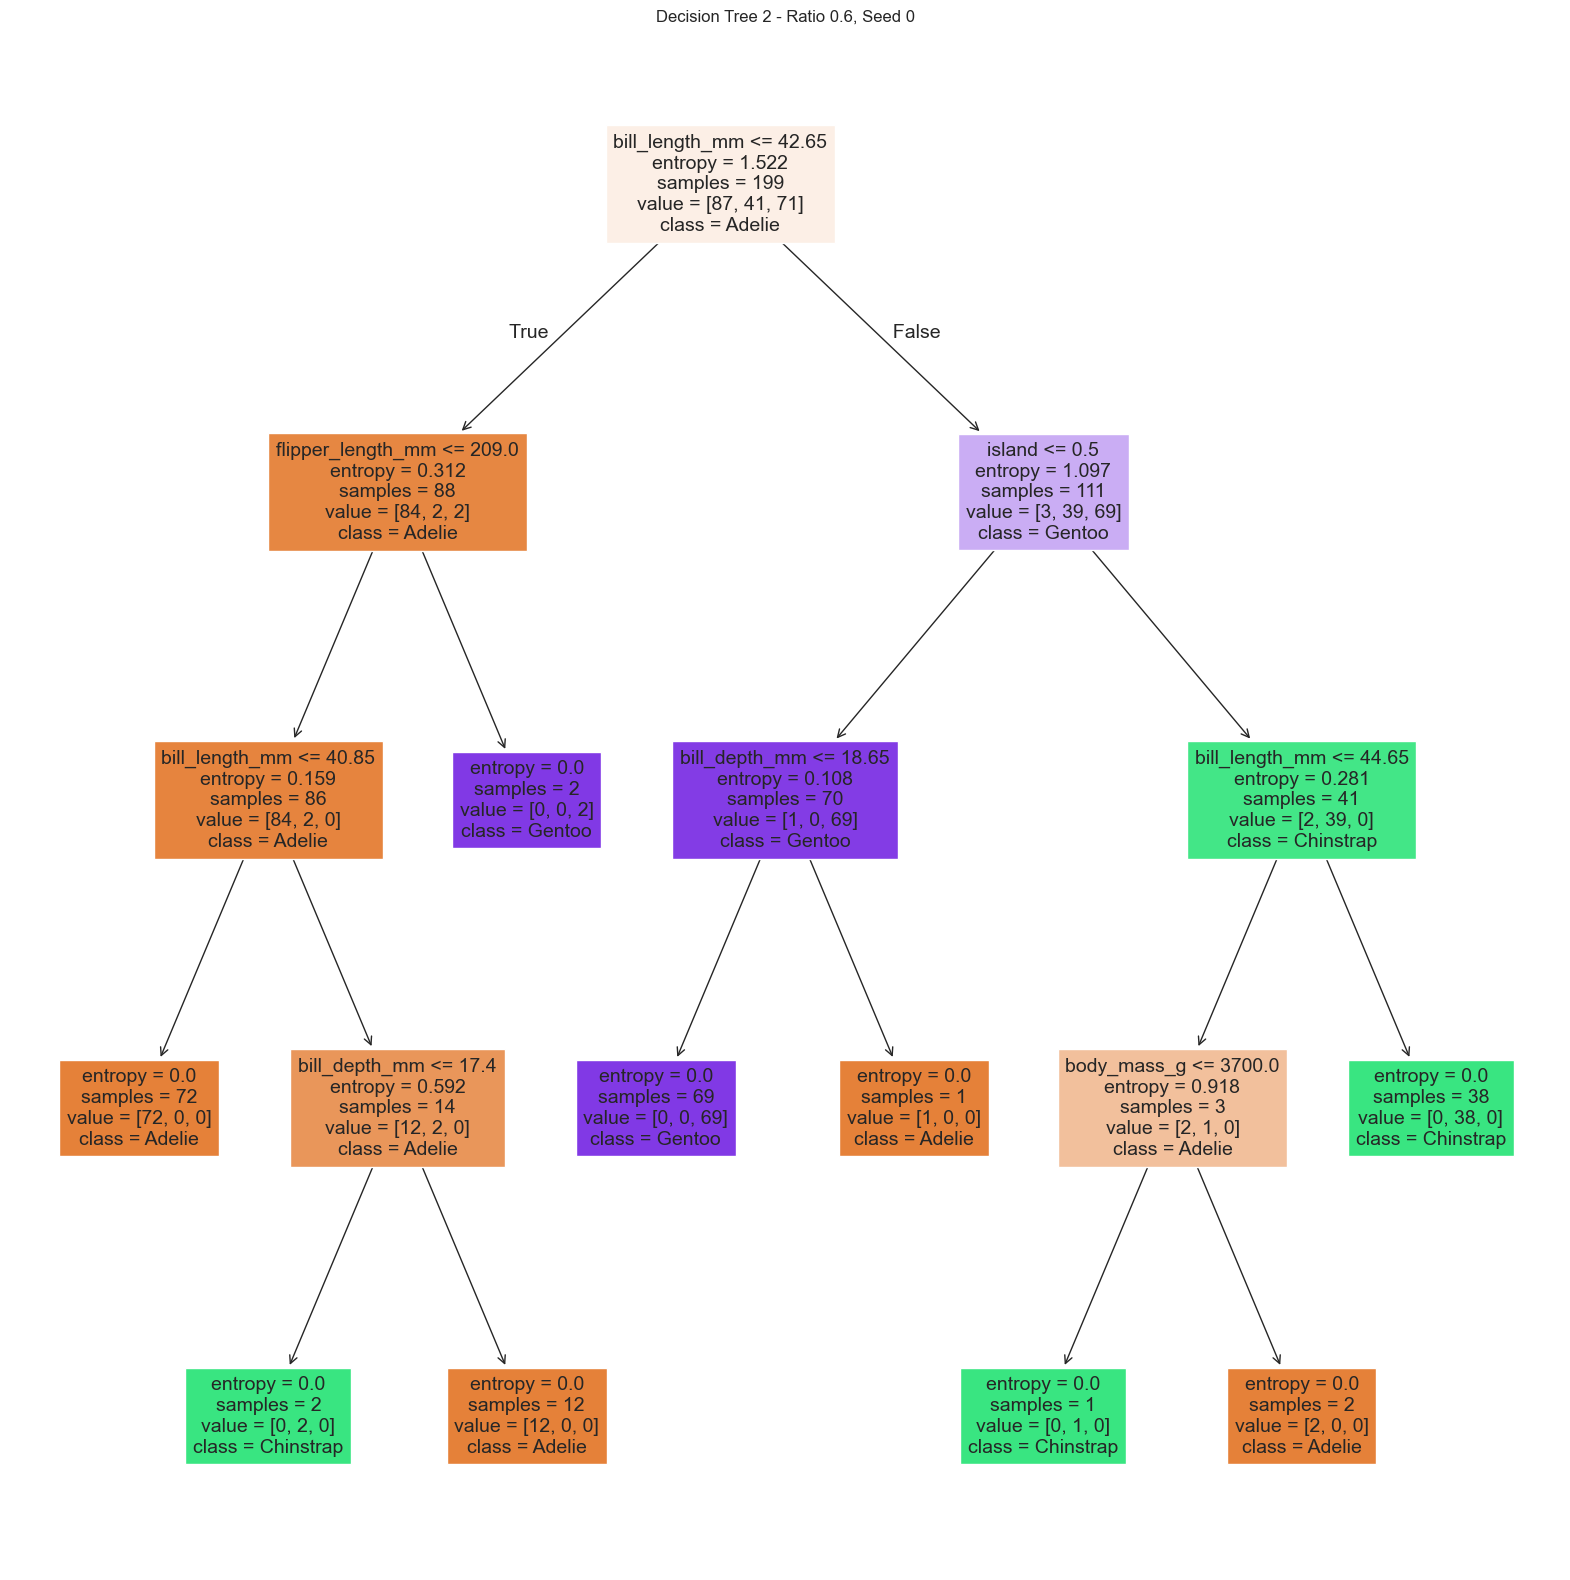

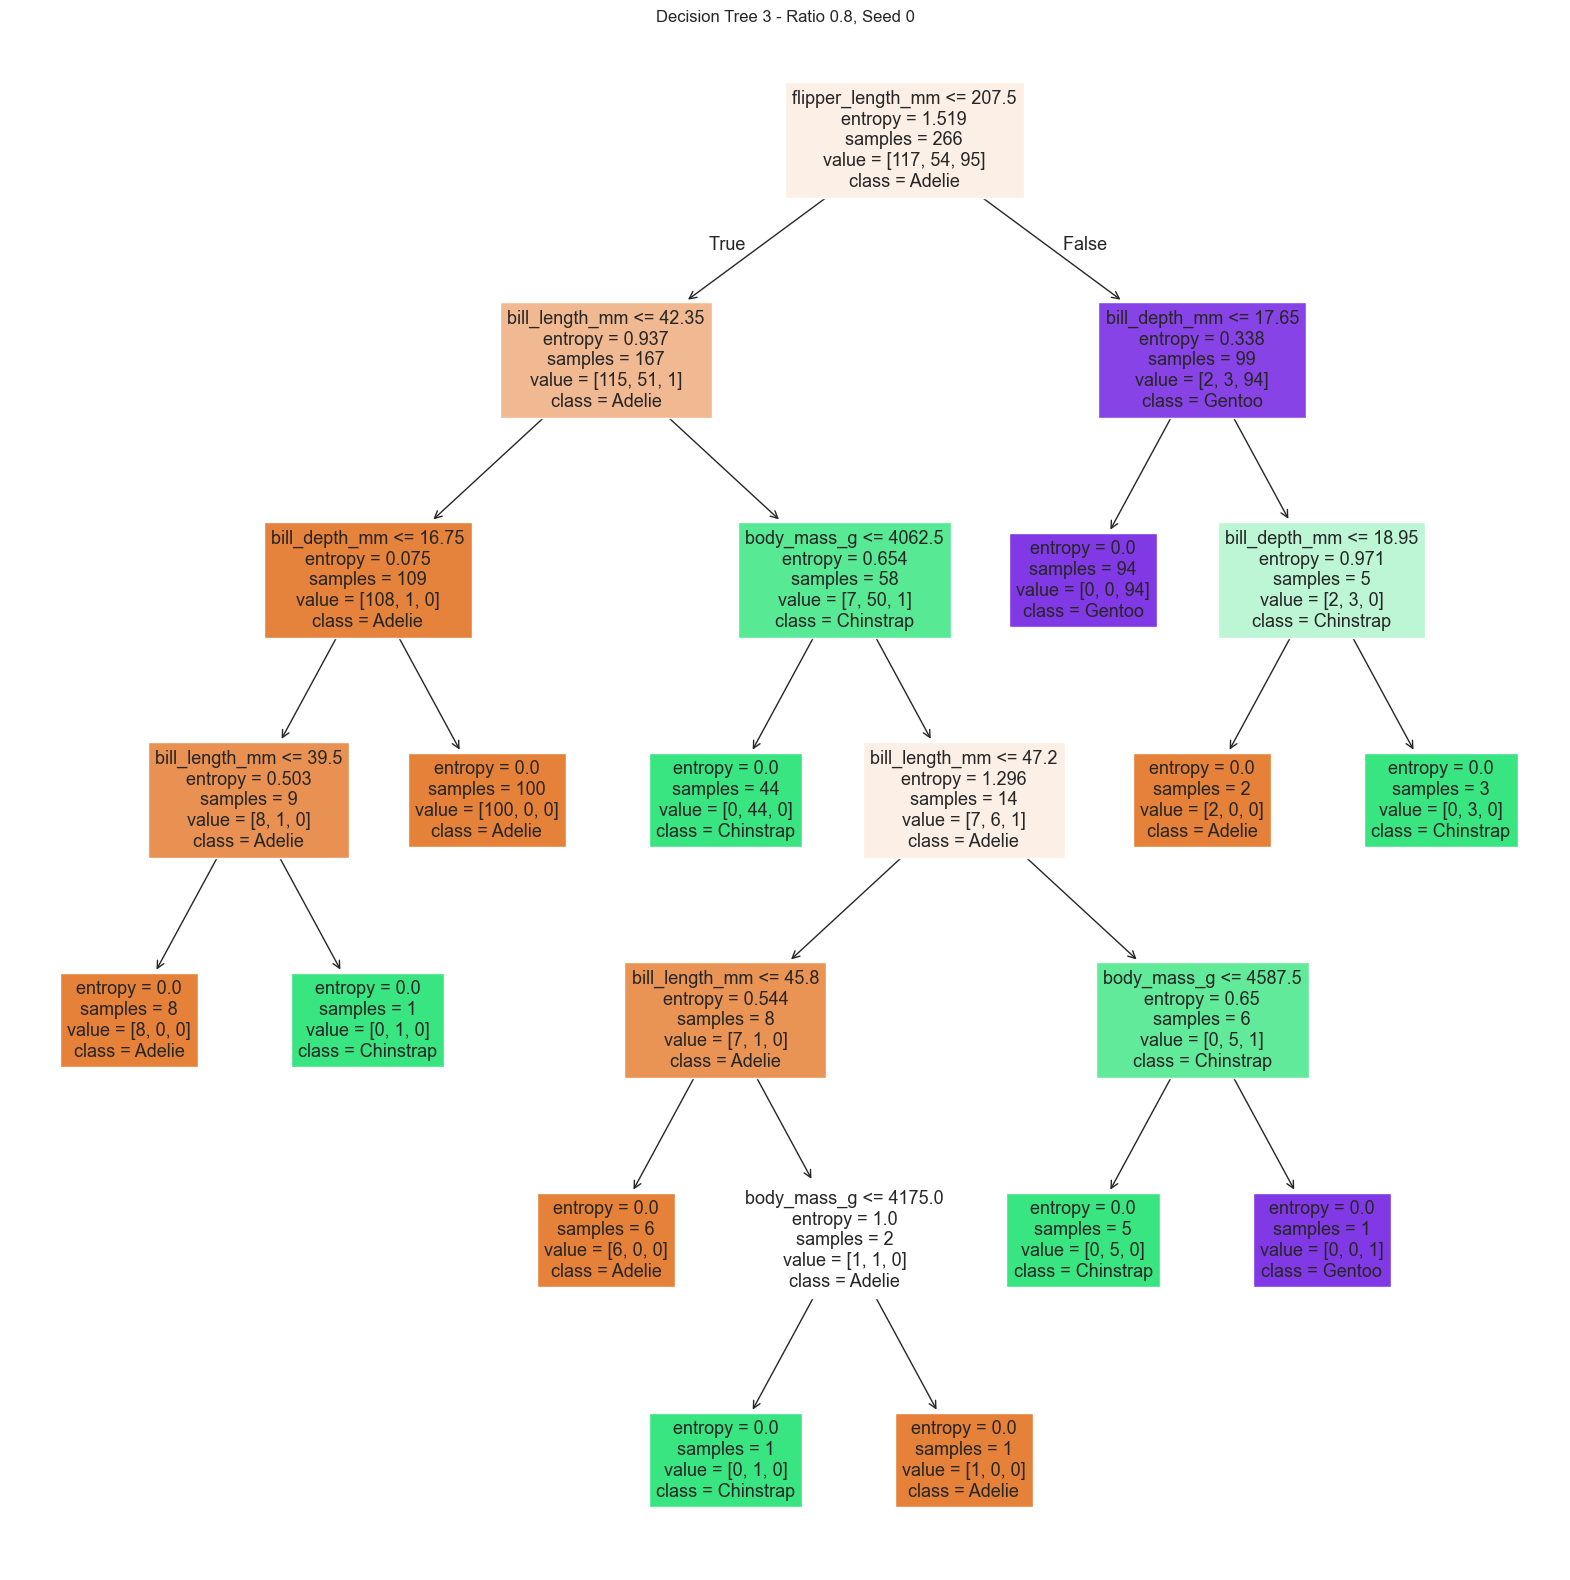

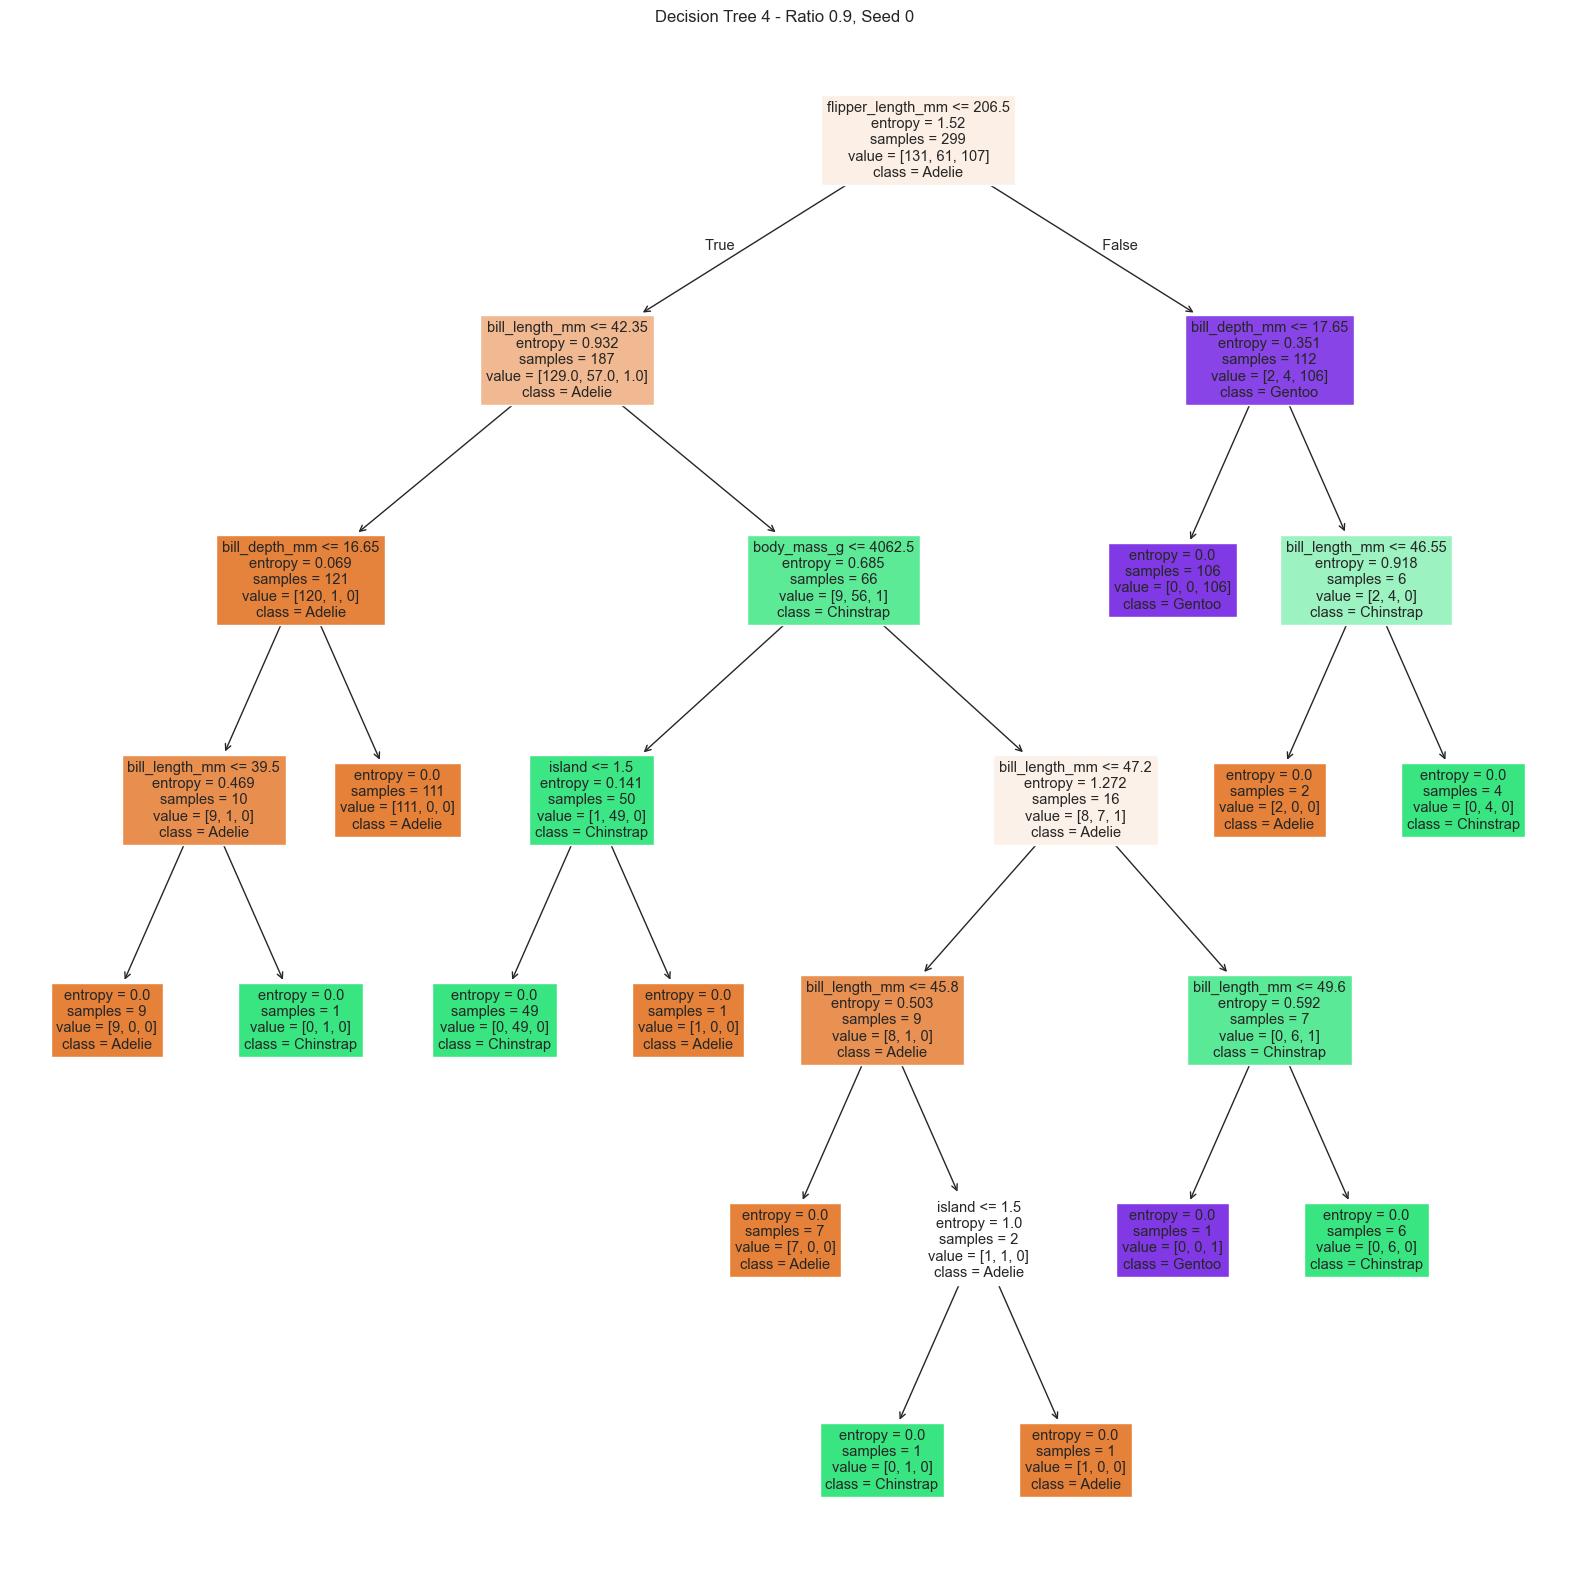

In [6]:
models = []

for i, example in enumerate(datasets):
    
    # Train the model
    model = DecisionTreeClassifier(random_state=example['seed'], criterion='entropy')
    model.fit(example['feature_train'], example['label_train'])
    
    # Save the model to the list
    models.append(model)

    # Plot the decision tree
    plt.figure(figsize=(20, 20))
    plot_tree(model, 
              feature_names=feature_encoded.columns, 
              class_names=model.classes_, 
              filled=True)
    plt.title(f"Decision Tree {i+1} - Ratio {example['ratio']}, Seed {example['seed']}")
    plt.show()


II.2 Evaluation


--- Evaluation for Model 1 — Ratio 0.4 — Seed 0 ---
Accuracy: 0.9650

Classification Report:
              precision    recall  f1-score   support

      Adelie       0.97      0.95      0.96        88
   Chinstrap       0.91      0.95      0.93        41
      Gentoo       1.00      0.99      0.99        71

    accuracy                           0.96       200
   macro avg       0.96      0.96      0.96       200
weighted avg       0.97      0.96      0.97       200



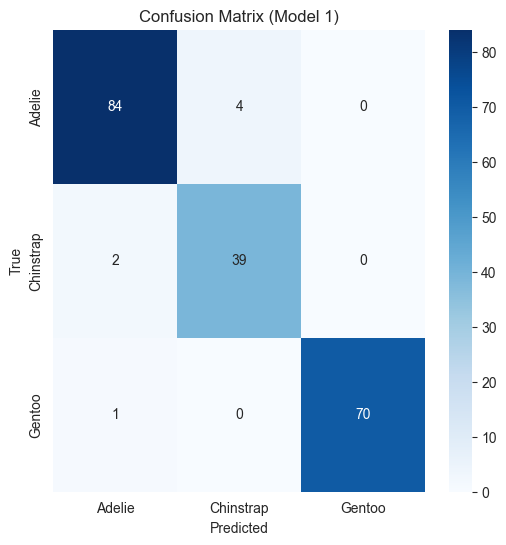


--- Evaluation for Model 2 — Ratio 0.6 — Seed 0 ---
Accuracy: 0.9627

Classification Report:
              precision    recall  f1-score   support

      Adelie       1.00      0.92      0.96        59
   Chinstrap       0.87      1.00      0.93        27
      Gentoo       0.98      1.00      0.99        48

    accuracy                           0.96       134
   macro avg       0.95      0.97      0.96       134
weighted avg       0.97      0.96      0.96       134



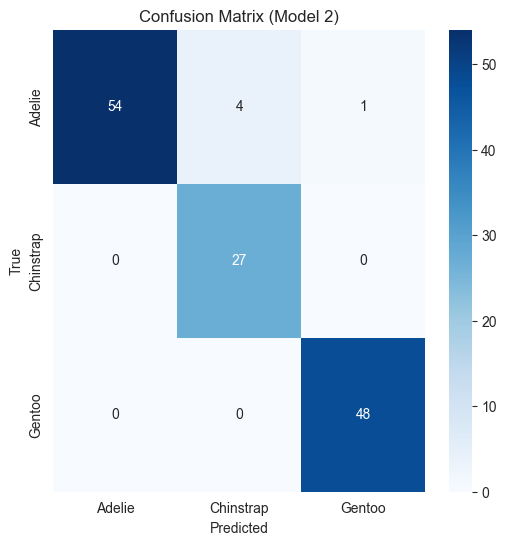


--- Evaluation for Model 3 — Ratio 0.8 — Seed 0 ---
Accuracy: 0.9701

Classification Report:
              precision    recall  f1-score   support

      Adelie       0.97      0.97      0.97        29
   Chinstrap       0.93      1.00      0.97        14
      Gentoo       1.00      0.96      0.98        24

    accuracy                           0.97        67
   macro avg       0.97      0.97      0.97        67
weighted avg       0.97      0.97      0.97        67



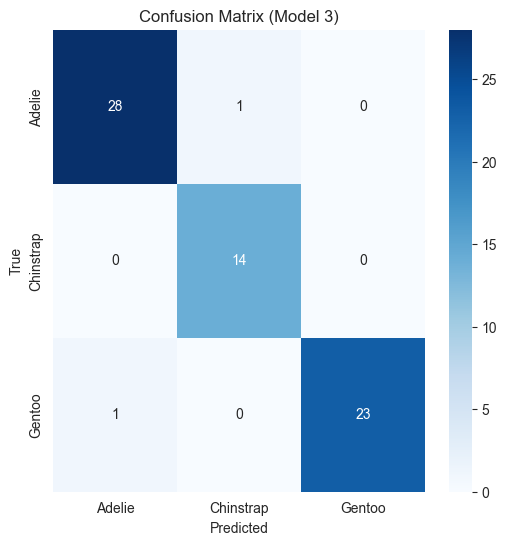


--- Evaluation for Model 4 — Ratio 0.9 — Seed 0 ---
Accuracy: 0.9706

Classification Report:
              precision    recall  f1-score   support

      Adelie       1.00      1.00      1.00        15
   Chinstrap       1.00      0.86      0.92         7
      Gentoo       0.92      1.00      0.96        12

    accuracy                           0.97        34
   macro avg       0.97      0.95      0.96        34
weighted avg       0.97      0.97      0.97        34



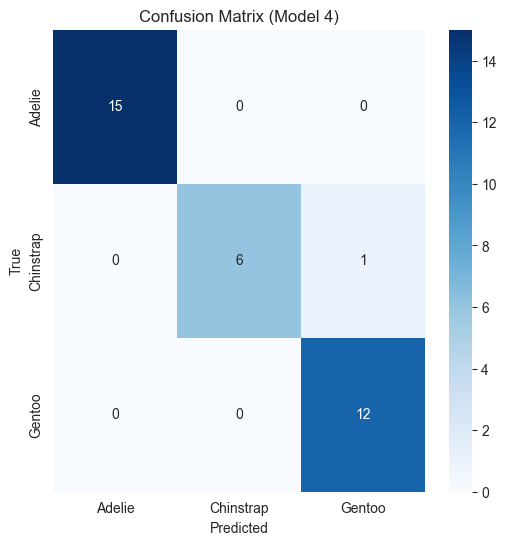

In [7]:
for i, model in enumerate(models):
    example = datasets[i]
    X_test = example['feature_test']
    y_test = example['label_test']
    
    # Predict and compute accuracy
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n--- Evaluation for Model {i+1} — Ratio {example['ratio']} — Seed {example['seed']} ---")
    print(f"Accuracy: {acc:.4f}\n")
    
    # Classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title(f"Confusion Matrix (Model {i+1})")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

In [8]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Lấy 1 dataset 80/20 ra dùng (ví dụ dataset số 11 bạn gửi)
example = datasets[10]  # datasets[10] vì index bắt đầu từ 0, Dataset 11 là datasets[10]

depths = [None, 2, 3, 4, 5, 6, 7]
accuracy_results = []

for depth in depths:
    model = DecisionTreeClassifier(max_depth=depth, random_state=example['seed'], criterion='entropy')
    model.fit(example['feature_train'], example['label_train'])
    y_pred = model.predict(example['feature_test'])

    acc = accuracy_score(example['label_test'], y_pred)
    accuracy_results.append((depth, acc))

    # Plot Decision Tree
    plt.figure(figsize=(20, 10))
    plot_tree(model, 
              feature_names=feature_encoded.columns, 
              class_names=model.classes_,
              filled=True)
    plt.title(f"Decision Tree (max_depth={depth}) - Accuracy: {acc:.2f}")
    plt.show()

# In ra bảng kết quả
print("\n=== Accuracy Report ===")
print("Max Depth | Accuracy")
for depth, acc in accuracy_results:
    print(f"{str(depth):9} | {acc:.4f}")

IndexError: list index out of range